# The Bayesian Sampler model is roughly:

$$P_{BS}(A) \sim Beta(\beta + S(A), \beta+F(A))$$

Where $S(A)$ and $F(A)$ are the number of success and failures sampled.

We can rewrite that:

$$P_{BS}(A) \sim Beta(\beta + \pi(A)N, \beta+(1-\pi(A))N)$$


Where $\pi(A)$ is the proportion of successes in the mental simulation with $N$ samples and is a function of the true underlying model probability, $p(A)$. It is distributed:

$$\pi(A) \sim Beta(p(A)*N, (1-p(A))*N)$$

To which we assign a uniform prior (or the multidimensional dirichlet equivalent):

$$p(A) \sim Beta(1,1)$$

In [1]:
%config IPCompleter.use_jedi = False
import torch as t
import pyro

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal

import numpy as np
import pandas as pd
import seaborn as sns
import functools

t.set_default_tensor_type(t.DoubleTensor)

In [2]:
## starting with just one P b/c I am struggling w/ python rustiness and filepaths
from dfply import *
import glob
import pandas as pd

## just to get the skeleton of the final data format
df_raw = pd.read_csv("osfstorage-archive/Experiment 2/PrEstExp_001_111218_115935.csv")
df = (df_raw >> 
      group_by(X.querytype) >> 
      summarize(estimate = X.estimate.mean()) >>
      mutate(estimate = X.estimate/100.)
     )
     
## data munging (for later)

# conjdisj_trials = ["AorB","notAorB","AornotB","notAornotB", "AandB", "notAandB", "AandnotB", "notAandnotB"]
# simple_df = df[~df.querytype.isin(conjdisj_trials)]
# conjdisj_df = df[df.querytype.isin(conjdisj_trials)]

In [3]:

trial_funcs = dict({
    "AandB": lambda theta: t.matmul(theta, t.tensor([1.,0.,0.,0.])) ,
    "AandnotB": lambda theta: t.matmul(theta, t.tensor([0.,1.,0.,0.])),
    "notAandB": lambda theta: t.matmul(theta, t.tensor([0.,0.,1.,0.])),
    "notAandnotB": lambda theta: t.matmul(theta, t.tensor([0.,0.,0.,1.])),
    "A":lambda theta: t.matmul(theta, t.tensor([1.,1.,0.,0.])),
    "B":lambda theta: t.matmul(theta, t.tensor([1.,0.,1.,0.])),
    "notA":lambda theta: t.matmul(theta, t.tensor([0.,0.,1.,1.])),
    "notB":lambda theta: t.matmul(theta, t.tensor([0.,1.,0.,1.])),
    "AorB":lambda theta: t.matmul(theta, t.tensor([1.,1.,1.,0.])),
    "AornotB":lambda theta: t.matmul(theta, t.tensor([1.,1.,0.,1.])),
    "notAorB":lambda theta: t.matmul(theta, t.tensor([0.,1.,1.,1.])),
    "notAornotB":lambda theta: t.matmul(theta, t.tensor([0.,1.,0.,1.])),
    
    "AgB": lambda theta: t.div( t.matmul(theta, t.tensor([1.,0.,0.,0.])), t.matmul(theta, t.tensor([1.,0.,1.,0.])) ),
    "notAgB": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,1.,0.])), t.matmul(theta, t.tensor([1.,0.,1.,0.])) ),
    "AgnotB": lambda theta: t.div( t.matmul(theta, t.tensor([0.,1.,0.,0.])), t.matmul(theta, t.tensor([0.,1.,0.,1.])) ),
    "notAgnotB": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,0.,1.])), t.matmul(theta, t.tensor([0.,1.,0.,1.])) ),
    "BgA": lambda theta: t.div( t.matmul(theta, t.tensor([1.,0.,0.,0.])), t.matmul(theta, t.tensor([1.,1.,0.,0.])) ),
    "notBgA": lambda theta: t.div( t.matmul(theta, t.tensor([0.,1.,0.,0.])), t.matmul(theta, t.tensor([1.,1.,0.,0.])) ),
    "BgnotA": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,1.,0.])), t.matmul(theta, t.tensor([0.,0.,1.,1.])) ),
    "notBgnotA": lambda theta: t.div( t.matmul(theta, t.tensor([0.,0.,0.,1.])), t.matmul(theta, t.tensor([0.,0.,1.,1.])) )
})


def dm_probs(trial_data, theta, n_obs):
    ## compute implied subj. probability from latent theta and trial type
    ## this is a vectorized solution: https://bit.ly/2P6mMcD
    p = t.tensor([])
    for i in range(0, n_obs):
        temp = trial_funcs[trial_data[i]](theta)
        p = t.cat( (p, t.tensor([temp])), 0)

    return p


In [20]:
def sim_sampling(p, beta, N, k):
    p_bs = p * N / (N + 2.*beta) + beta/(N + 2.*beta)
    return dist.Beta(p_bs*k, (1-p_bs)*k).sample()

## ------
## simulate data into pandas DataFrame
## -------
n_participants = 100
n_blocks = 4

trial_types = list(df.querytype)

n_trial_types = len(trial_types)

trials = trial_types*n_blocks
blocks = list(np.repeat(np.array(list(range(0, n_blocks))), n_trial_types))

all_participants = list(np.repeat(np.array(list(range(0, n_participants))), n_trial_types*n_blocks))
all_trials = trials*n_participants
all_blocks = blocks*n_participants
all_responses = t.ones(0)

all_thetas = []

for i in range(0, n_participants):
    theta = dist.Dirichlet(t.ones(4)).sample()

    probs = dm_probs(trials, theta, len(trials))
    responses = sim_sampling(probs, 1, 10, 100)
    
    all_thetas.append(theta)
    all_responses = t.cat((all_responses, responses))

sim_data = pd.DataFrame(
    data = {
        "ID": all_participants,
        "querytype": all_trials, 
        "block": all_blocks,
        "response": all_responses
    }
)

sim_data.head()

,ID,querytype,block,response
0,0,A,0,0.356791
1,0,AandB,0,0.318594
2,0,AandnotB,0,0.122135
3,0,AgB,0,0.301372
4,0,AgnotB,0,0.254792


In [21]:
## now munge pandas dataframe into what is fed into model
def sort_trials(trial_data, observations):
    output = dict()
    for key in set(trial_data):
        output[key] = t.ones(0)
        
    for i in range(0, len(trial_data)):
        output[trial_data[i]] = t.cat( (output[trial_data[i]], t.tensor([observations[i]])) )
        
    return output

test_data = sort_trials(sim_data.querytype, sim_data.response)
test_info = {"n_Ps":n_participants, "n_blocks":n_blocks}

In [22]:
## define model -- need to come up with better practices regarding the munging of data and modeling

def bayesian_sampler(data, info):

    n_obs = len(data["A"])
    n_total_obs = len(data.keys())*n_obs
    n_Ps = info["n_Ps"]
    n_blocks = info["n_blocks"]

    # population level parameters/priors
    beta = pyro.sample("beta", dist.HalfCauchy(.25))
    N = pyro.sample("N", dist.HalfCauchy(5))
    k = pyro.sample("k", dist.HalfCauchy(10)) ## noise, all causes

    # need a theta per person/querytype (yes?)    

    thetas = [pyro.sample("theta_{}".format(j), dist.Dirichlet(t.ones(4))) for j in range(0,n_Ps)]
    theta = t.stack(thetas) # this works, not 100% sure if it's necessary vs just creating a n x 4 dirichlet

    for trial in data.keys():
        f = trial_funcs[trial]
        pi = f(theta).repeat_interleave(n_blocks) # changed from repeat() -- this fixed it!
        p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta) 
        
        yhat = pyro.sample("yhat_{}".format(trial), dist.Beta(p_bs*k, (1.-p_bs)*k), obs=data[trial]) # ???
    
    return None

In [ ]:
from pyro.infer.mcmc import NUTS, MCMC

pyro.clear_param_store()

nuts_kernel = NUTS(bayesian_sampler, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=250)

mcmc.run(test_data, test_info)
mcmc.summary()

Warmup:   1%|▏         | 11/750 [01:10,  6.91s/it, step size=4.58e-03, acc. prob=0.678]

In [9]:
## compare latent inferred Ps against true latents
all_thetas

[tensor([0.1864, 0.0464, 0.2202, 0.5470]),
 tensor([0.2028, 0.1089, 0.5361, 0.1522]),
 tensor([0.2259, 0.0951, 0.3082, 0.3708]),
 tensor([0.5347, 0.2742, 0.0084, 0.1827])]

This recovers the latent probabilities! It doesn't quite recover N and beta though

array([[<AxesSubplot:ylabel='theta_1\n0'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='theta_1\n1'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='theta_1\n2'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='theta_1\n0', ylabel='theta_1\n3'>,
        <AxesSubplot:xlabel='theta_1\n1'>,
        <AxesSubplot:xlabel='theta_1\n2'>,
        <AxesSubplot:xlabel='theta_1\n3'>]], dtype=object)

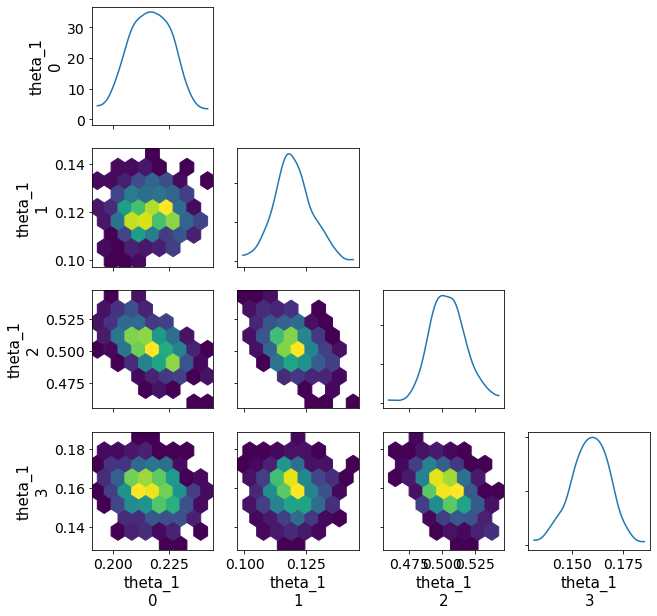

In [11]:
import arviz as az

data = az.from_pyro(mcmc)

az.plot_pair(
    data,
    var_names=["theta_1"],
#     coords={"school": ["Choate", "Phillips Andover"]},
    kind="hexbin",
    marginals=True,
    figsize=(10, 10),
)

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='beta', ylabel='N'>, <AxesSubplot:>]],
      dtype=object)

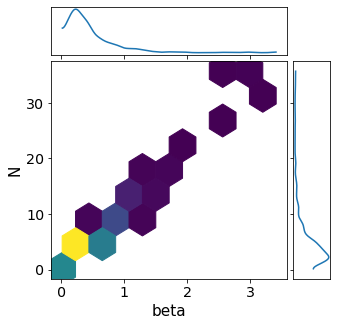

In [16]:
az.plot_pair(
    data,
    var_names=["beta","N"],
#     coords={"school": ["Choate", "Phillips Andover"]},
    kind="hexbin",
    marginals=True,
    figsize=(5, 5),
)

As expected, estimates of beta and N are highly correlated with one another. These two values are not really identifiable.

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='k', ylabel='beta'>, <AxesSubplot:>]],
      dtype=object)

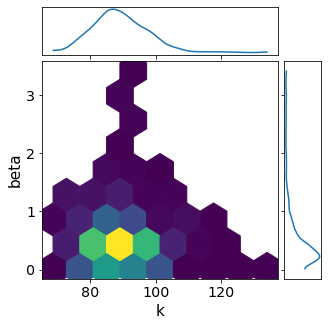

In [18]:
az.plot_pair(
    data,
    var_names=["k","N"],
#     coords={"school": ["Choate", "Phillips Andover"]},
    kind="hexbin",
    marginals=True,
    figsize=(5, 5),
)

k is relatively independent of both Beta and k though, so that's good.